In [18]:
using JuMP
using SumOfSquares
using DynamicPolynomials
using Mosek
using Plots
using MosekTools
using DifferentialEquations
using PyPlot
using LinearAlgebra
using LinearAlgebra
using Random
@polyvar x y


(x, y)

In [19]:

function get_vf_for_parameters(params)
    a1, b1, a2, b2, c1, c2 = params
    f(u1, u2) =    [-a1 * u1 + b1*(c1-u1)*u2
                    -a2 * u2 + b2*(c2-u2)*u1]
    return f
end

struct OdeDiverges <: Exception end
function solve_ode(vf, x0; verbose=true, tspan = (0., 30.0))
    if verbose
        println("Solving ODE from x0=$x0")
    end
    function vf_for_solver(dx, x, params, t)
        dx[1], dx[2] = vf(x[1], x[2])
    end
    prob = ODEProblem(vf_for_solver, x0, tspan)
    sol = DifferentialEquations.solve(prob)
    trange = range(tspan[1], stop=tspan[2], length=10)
    if verbose
        @show size(sol)
    end
    if size(sol, 2) <= 1
        throw(OdeDiverges())
    end
    sol = hcat(sol.(trange)...)
    return (sol[1, :], sol[2, :])
end


function plot_vectorfield(f, limits_x, limits_y)
    x = range(limits_x[1], stop=limits_x[2], length=limits_x[3])
    y = range(limits_y[1], stop=limits_y[2], length=limits_y[3])
    xx = broadcast((x, y) -> x, x', y)
    yy = broadcast((x, y) -> y, x', y)
    fXY = broadcast(f, x', y)
    fXY_X = map(u -> u[1], fXY)
    fXY_Y = map(u -> u[2], fXY)
    PyPlot.streamplot(xx, yy, fXY_X, fXY_Y, linewidth=1)
end

function plot_box()
    PyPlot.plot([0, 0, 1, 1, 0], [0, 1, 1, 0, 0], "--", color=:black)
end

function plot_univarite_poly(poly, var, limits=(-1, 1, 100); kwargs...)
    print(kwargs...)
    poly_as_func = ti -> poly(var => ti)
    t_range = collect(range(limits[1], stop=limits[2], length=limits[3]))
    p_t = map(poly_as_func, t_range)
    PyPlot.plot(t_range, p_t; kwargs...)
end


function plot_restriction_to_box(poly)
    limits = (-.1, 1.1, 100)
    for side in (0, 1)
        plot_univarite_poly(subs(poly[1], x=>side), y, limits, label="\$p_1($side, y)\$")
        plot_univarite_poly(subs(poly[2], y=>side), x, limits, label="\$p_2(x, $side)\$")
        plot_univarite_poly(0*x, x, limits, ls="--", color=:black)

    end
    PyPlot.legend()
end



plot_restriction_to_box (generic function with 1 method)

Solving ODE from x0=[0.7, 0.3]
size(sol) = (2, 10)
Solving ODE from x0=[0.4, 0.1]

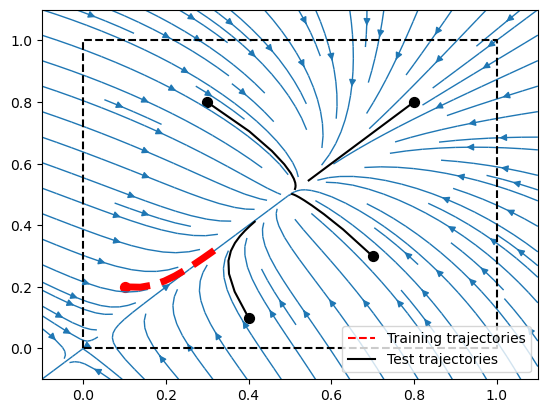


size(sol) = (2, 11)
Solving ODE from x0=[0.8, 0.8]
size(sol) = (2, 8)
Solving ODE from x0=[0.3, 0.8]
size(sol) = (2, 11)
Solving ODE from x0=[0.1, 0.2]
size(sol) = (2, 10)


PyObject <matplotlib.legend.Legend object at 0x7fdc7cb91b50>

In [20]:
gr(size=(600,400))


ode_p = [.05 .1 .05 .1 1. 1.]
ff = get_vf_for_parameters(ode_p)

plot_vectorfield(ff, (-0.1, 1.1, 50), (-0.1, 1.1, 50))

initial_conditions = [[.1, .2], [.7, .3], [.4, .1], [.8, .8], [.3, .8]]
#initial_conditions = [rand(2) for _ in 1:10]
for x0 in initial_conditions[2:end]
    sol = solve_ode(ff, x0, tspan = (0., 30.0))
    PyPlot.plot(sol..., color=:black)
    PyPlot.scatter(x0[1], x0[2], color=:black, s=50)
end

x0 = initial_conditions[1]
sol = solve_ode(ff, x0)
PyPlot.plot(sol..., color=:red, ls="--", lw=5)
PyPlot.scatter(x0[1], x0[2], color=:red, s=50)
PyPlot.plot([], [], color=:red, ls="--", label="Training trajectories")
PyPlot.plot([], [], color=:black, label="Test trajectories")
plot_box()
PyPlot.legend()


In [21]:
function get_training_data(x0; noise_level=1e-6, verbose=true)
    Random.seed!(0)
    training_x = hcat(solve_ode(ff, x0; verbose=verbose)...)'
    training_xdot = ff.(training_x[1, :], training_x[2, :])
    training_xdot = hcat(training_xdot...)
    training_xdot = training_xdot + noise_level * randn(size(training_xdot))
    return training_x, training_xdot
end


∞ = 1e9
function test_error(vf, initial_conditions; verbose=false)
    error = 0
    for x0 in initial_conditions
        sol = []
        try
            sol = solve_ode(vf, x0, verbose=verbose)
        catch y
            return ∞
        end
        true_sol =  solve_ode(ff, x0, verbose=verbose)
        for  i=1:size(sol, 1)
            error += norm(sol[i] .- true_sol[i])
        end
        if verbose
            println("at $x0, error = $error")
        end
    end
    return error / size(initial_conditions, 1)
end

# should ne 0
test_error(ff, initial_conditions[2:end])


0.0

In [38]:

function fit_polynomial_to_data(training_x, training_xdot;
                                deg=2,
                                solver=nothing, 
                                box_invariance=false, 
                                monotonicity=false,
                                equilibrium_points=false,
                                regularization = false,
                                α = 1e-3,
                                verbose = true)
 
    if solver == nothing
        solver = with_optimizer(Mosek.Optimizer, QUIET=true)
    end
    model = SOSModel(solver)

    if verbose
        @show size(training_xdot)
        @show size(training_x)
        @show deg
        @show solver
        @show model
        @show box_invariance
        @show monotonicity
        @show equilibrium_points
        @show regularization
    end

    # define polynomial variable
    if verbose
        @show "Define polynomial variable"
    end
    mon_xy = monomials((x, y), 0:deg)
    @variable model p1 Poly(mon_xy)
    @variable model p2 Poly(mon_xy)
    p = [p1; p2]

    if verbose
        @show "Define p(training)"
    end
    p_at_x = [map((u1,u2) -> pi(x=>u1, y=>u2),
                training_x[1, :], training_x[2, :])
              for pi in [p1, p2]]
    p_at_x = hcat(p_at_x...)'

    if verbose
        @show "Side info"
    end
    # side information
    if box_invariance
        int_y = @set y >= 0 && 1 - y >= 0
        @constraint(model, subs(p1, x=>0) >= 0, domain=int_y )
        @constraint(model, -subs(p1, x=>1) >= 0, domain=int_y )

        int_x = @set x >= 0 && 1 - x >= 0
        @constraint(model, subs(p2, y=>0) >= 0, domain=int_x )
        @constraint(model, -subs(p2, y=>1) >= 0, domain=int_x )
    end

    if monotonicity
        Box = @set 1 - x >=  0 && x >= 0 && 1 - y >= 0 && y >= 0
        @constraint(model, differentiate(p1, y) >= 0, domain=Box)
        @constraint(model, differentiate(p2, x) >= 0, domain=Box)
    end
    if equilibrium_points
        @constraint(model, subs(p1, x=>0, y=>0) == 0)
        @constraint(model, subs(p2, x=>0, y=>0) == 0)
    end

    if verbose
        @show "Define objective"
    end

        
    # objective
    @variable model least_squares_error 
    #@constraint model sum((p_at_x - training_xdot).^2) <= least_squares_error
    @constraint(model, soc, norm(p_at_x - training_xdot) <= least_squares_error)

    objective = least_squares_error
    if regularization        
        @variable model l2_penalty 
        coeffs = coefficients.(p)
        coeffs = hcat(coeffs...)
        @constraint model norm(coeffs) <= l2_penalty        
        objective = objective + α * l2_penalty
    end
    
    @objective model Min objective
    if verbose
        @show "Solving"
    end
    # solve model
    JuMP.solve(model)

    p_least_squares = getvalue(p)
    if verbose
        @show getobjectivevalue(model)
    end
    p_as_f = (a, b) -> map(pi -> pi(x=>a, y=>b), p_least_squares)
    
    return p_as_f, x, y, p_least_squares, getobjectivevalue(model)
end


fit_polynomial_to_data (generic function with 1 method)

In [39]:
verbose = false
deg = 2
noise_level=1e-3
training_x, training_xdot = get_training_data(initial_conditions[1], noise_level=noise_level, verbose=verbose)

kwargs = [
    :box_invariance=> true,
    :monotonicity => false,
    :equilibrium_points => false,
    :regularization => true
]
p_opt_as_f, x, y, p_opt, opt_value = 
fit_polynomial_to_data(training_x, training_xdot; verbose=verbose, deg=deg, kwargs...)
p_as_str = join(string.(round.(p_opt, digits=4)), "\n")
tracking_error = test_error(p_opt_as_f, initial_conditions[2:end])
println("Least squares fit: $opt_value, test_error $tracking_error")
kwargs_as_str_array = 
        [string(k.first, "=", k.second)  for k in kwargs]
fname = kwargs_as_str_array
fname = hcat(fname..., "degree=$(deg)", "noise_level=$(noise_level)")
fname = join(fname, ", ")
p_opt


LoadError: StackOverflowError:

┌ Warning: Not solved to optimality, status: Stall
└ @ JuMP /Users/maroxe/.julia/packages/JuMP/PbnIJ/src/solvers.jl:212
┌ Warning: Instability detected. Aborting
└ @ DiffEqBase /Users/maroxe/.julia/packages/DiffEqBase/VM2Bp/src/integrator_interface.jl:162
┌ Warning: Not solved to optimality, status: Stall
└ @ JuMP /Users/maroxe/.julia/packages/JuMP/PbnIJ/src/solvers.jl:212
┌ Warning: Instability detected. Aborting
└ @ DiffEqBase /Users/maroxe/.julia/packages/DiffEqBase/VM2Bp/src/integrator_interface.jl:162
┌ Warning: Not solved to optimality, status: Stall
└ @ JuMP /Users/maroxe/.julia/packages/JuMP/PbnIJ/src/solvers.jl:212
┌ Warning: Instability detected. Aborting
└ @ DiffEqBase /Users/maroxe/.julia/packages/DiffEqBase/VM2Bp/src/integrator_interface.jl:162
┌ Warning: Not solved to optimality, status: Stall
└ @ JuMP /Users/maroxe/.julia/packages/JuMP/PbnIJ/src/solvers.jl:212
┌ Warning: Instability detected. Aborting
└ @ DiffEqBase /Users/maroxe/.julia/packages/DiffEqBase/VM2Bp/src/inte

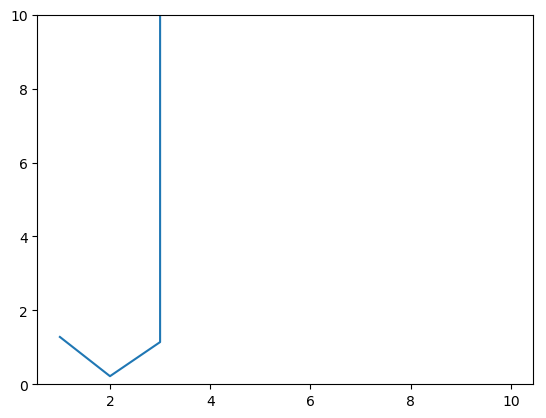

┌ Warning: Not solved to optimality, status: Stall
└ @ JuMP /Users/maroxe/.julia/packages/JuMP/PbnIJ/src/solvers.jl:212
┌ Warning: Instability detected. Aborting
└ @ DiffEqBase /Users/maroxe/.julia/packages/DiffEqBase/VM2Bp/src/integrator_interface.jl:162


(0, 10)

In [586]:
# tracking error vs degree
verbose = false
kwargs_side_info = [
    :box_invariance=> true,
    :monotonicity => true,
    :equilibrium_points => true,
]

kwargs_no_side_info = [
    :box_invariance=> true,
    :monotonicity => false,
    :equilibrium_points => false,
]

tracking_error_side_info = []
tracking_error_no_side_info = []

range_d = 1:10
for d=range_d
    p_opt_as_f, x, y, p_opt, opt_value = 
        fit_polynomial_to_data(training_x, training_xdot; verbose=verbose, deg=d, kwargs_side_info...)
    #@show(opt_value)
    #@show(p_opt)
    append!(tracking_error_side_info, test_error(p_opt_as_f, initial_conditions[2:end], verbose=verbose))
end
PyPlot.plot(range_d, tracking_error_side_info)
PyPlot.ylim(0, 10)

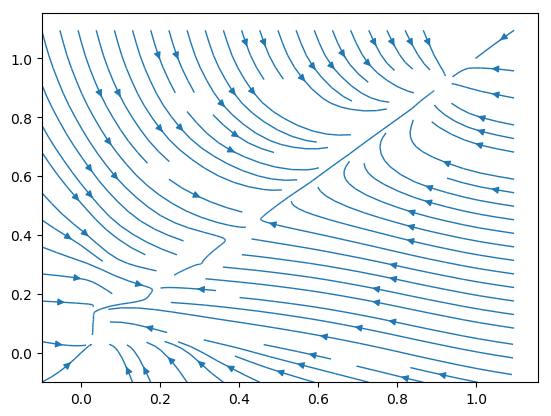

2-element Array{Polynomial{true,Float64},1}:
 -27411.519986993106x¹⁰ - 3318.680866285971x⁹y - 1884.9357683212788x⁸y² - 1458.8614967204812x⁷y³ - 1114.5942142941785x⁶y⁴ - 989.6490494992328x⁵y⁵ - 655.8112076423204x⁴y⁶ - 410.0096668841647x³y⁷ - 276.6778183214093x²y⁸ - 169.00470562794203xy⁹ - 4.467063455087425y¹⁰ - 3567.087097395888x⁹ + 3342.0499825143634x⁸y - 1907.167075536066x⁷y² + 1106.5711578800974x⁶y³ - 1141.0859786619692x⁵y⁴ + 844.1783759473518x⁴y⁵ - 557.2875930469189x³y⁶ + 834.9776890465137x²y⁷ - 358.5319080525216xy⁸ + 1003.794514228363y⁹ + 19022.567089042168x⁸ + 701.075812183354x⁷y + 1154.5769764663596x⁶y² + 533.6170128171278x⁵y³ + 521.7312086850128x⁴y⁴ + 337.8982216575032x³y⁵ + 91.38920794854262x²y⁶ - 192.5789371642442xy⁷ + 306.1499387154624y⁸ + 23213.93755283214x⁷ + 7727.803237422971x⁶y + 1965.6696457735402x⁵y² + 3367.1720581440036x⁴y³ + 678.005019440962x³y⁴ + 1988.2522518157928x²y⁵ - 231.22353076897923xy⁶ + 1559.511242497356y⁷ - 7110.215475392696x⁶ - 1402.8015393529054x⁵y - 1256.

In [591]:
plot_vectorfield(p_opt_as_f, (-0.1, 1.1, 10), (-0.1, 1.1, 10))
p_opt

In [590]:
plot_vectorfield(p_opt_as_f, (-0.1, 1.1, 10), (-0.1, 1.1, 10))
plot_box()
PyPlot.title("$(fname)\n$(p_as_str)\noptimal value $(opt_value)")
PyPlot.plot(training_x[1, :], training_x[2, :], color=:red, label="training data")
for x0 in initial_conditions
    sol = solve_ode(p_opt_as_f, x0, verbose=false,  tspan=(0., 1e-3))
    PyPlot.plot(sol..., color=:black)
    PyPlot.scatter(x0[1], x0[2], color=:black, s=50)
end

┌ Warning: Instability detected. Aborting
└ @ DiffEqBase /Users/maroxe/.julia/packages/DiffEqBase/VM2Bp/src/integrator_interface.jl:162


OdeDiverges: OdeDiverges()

In [413]:

test_error(p_opt_as_f, initial_conditions)

0.16016981841682493

In [ ]:
p_side_info_as_f, x, y, p_side_info, side_info_objective_value = 
fit_polynomial_to_data(deg, training_x, training_xdot, nothing, true)
print("Least squares fit: $side_info_objective_value")


In [ ]:

plot_vectorfield(p_least_squares_as_f, (-0.1, 1.1, 10), (-0.1, 1.1, 10))
plot_box()
PyPlot.title("Least squares fit")
PyPlot.plot(training_x[1, :], training_x[2, :], color=:red, label="training data")
#PyPlot.savefig("../LatexDrafts/img/learned_vf_diffusion_disease_with_side_info.png")

PyPlot.figure()
plot_box()
plot_vectorfield(p_side_info_as_f, (-0.1, 1.1, 10), (-0.1, 1.1, 10))
PyPlot.plot(training_x[1, :], training_x[2, :], color=:red, label="training data")
PyPlot.title("Least squares fit with monotonicity constraints")
#PyPlot.savefig("../LatexDrafts/img/learned_vf_diffusion_disease_without_side_info.png")


Solving ODE from x0=[0.1, 0.2]
Solving ODE from x0=[0.7, 0.3]
Solving ODE from x0=[0.4, 0.1]
Solving ODE from x0=[0.8, 0.8]
Solving ODE from x0=[0.3, 0.8]


┌ Warning: dt <= dtmin. Aborting. This is often an indicator that the differential equation is unstable or there is an error in the model specification. If you would like to force continuation with dt=dtmin, set force_dtmin=true
└ @ DiffEqBase /Users/maroxe/.julia/packages/DiffEqBase/VM2Bp/src/integrator_interface.jl:156


Solving ODE from x0=[0.1, 0.2]
Solving ODE from x0=[0.7, 0.3]
Solving ODE from x0=[0.4, 0.1]


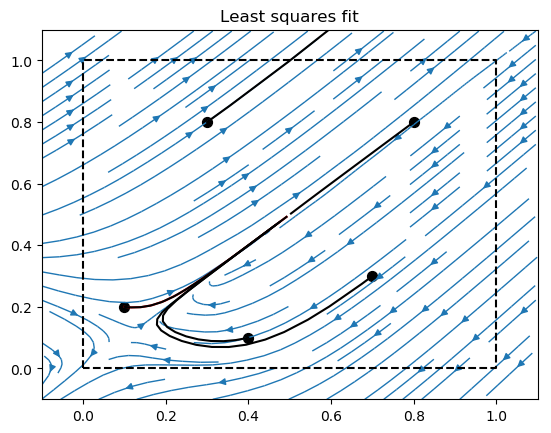

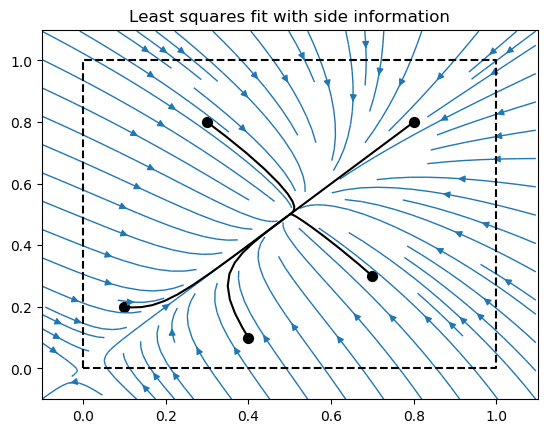

Solving ODE from x0=[0.8, 0.8]
Solving ODE from x0=[0.3, 0.8]


In [43]:
plot_box()
PyPlot.title("Least squares fit")
PyPlot.plot(training_x[1, :], training_x[2, :], color=:red, label="training data")

for x0 in initial_conditions
    sol = solve_ode(p_least_squares_as_f, x0)
    PyPlot.plot(sol..., color=:black)
    PyPlot.scatter(x0[1], x0[2], color=:black, s=50)
end
plot_vectorfield(p_least_squares_as_f, (-0.1, 1.1, 10), (-0.1, 1.1, 10))
PyPlot.xlim(-.1, 1.1)
PyPlot.ylim(-.1, 1.1)

PyPlot.savefig("../LatexDrafts/img/learned_vf_diffusion_disease_with_side_info.png")

PyPlot.figure()
plot_vectorfield(p_side_info_as_f, (-0.1, 1.1, 10), (-0.1, 1.1, 10))
plot_box()

for x0 in initial_conditions
    sol = solve_ode(p_side_info_as_f, x0)
    PyPlot.plot(sol..., color=:black)
    PyPlot.scatter(x0[1], x0[2], color=:black, s=50)
end
PyPlot.xlim(-.1, 1.1)
PyPlot.ylim(-.1, 1.1)
PyPlot.title("Least squares fit with side information")
PyPlot.savefig("../LatexDrafts/img/learned_vf_diffusion_disease_without_side_info.png")


:label => "\$p_1(0, y)\$":label => "\$p_2(x, 0)\$"Pair{Symbol,Any}(:ls, "--")Pair{Symbol,Any}(:color, :black):label => "\$p_1(1, y)\$":label => "\$p_2(x, 1)\$"Pair{Symbol,Any}(:ls, "--")Pair{Symbol,Any}(:color, :black)

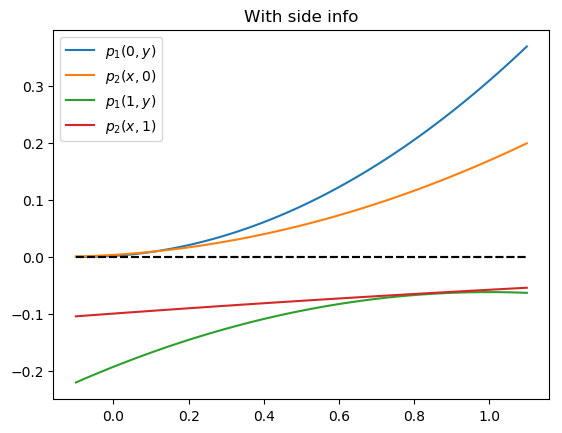

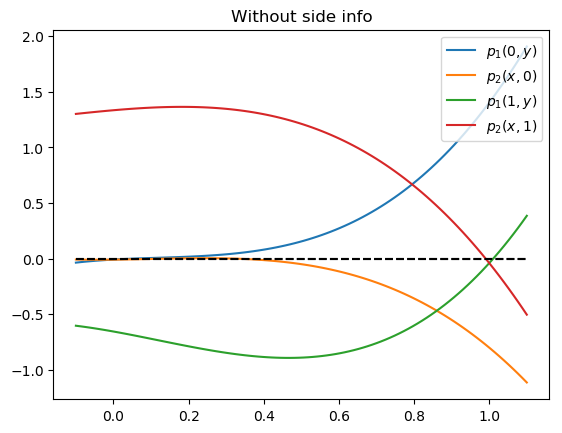

:label => "\$p_1(0, y)\$":label => "\$p_2(x, 0)\$"Pair{Symbol,Any}(:ls, "--")Pair{Symbol,Any}(:color, :black):label => "\$p_1(1, y)\$":label => "\$p_2(x, 1)\$"Pair{Symbol,Any}(:ls, "--")Pair{Symbol,Any}(:color, :black)

In [182]:
plot_restriction_to_box(p_side_info)
PyPlot.title("With side info")
PyPlot.savefig("../LatexDrafts/img/restriction_learned_vf_diffusion_disease_with_side_info.png")

PyPlot.figure()
plot_restriction_to_box(p_least_squares)
PyPlot.title("Without side info")
PyPlot.savefig("../LatexDrafts/img/restriction_learned_vf_diffusion_disease_without_side_info.png")




In [186]:
p_side_info

2-element Array{Polynomial{true,Float64},1}:
 -0.16260520063462186x³ + 0.5135369300484824x²y - 0.3970108981348706xy² - 0.024050291510291297x² - 0.29307119168435597xy + 0.2658754059861716y² - 0.008028084225693323x + 0.04182047826176107y + 0.0016446289314111077
 -0.130330232888354x²y - 0.08288956609068786xy² + 0.17061811677871858y³ + 0.12437107813893565x² + 0.08935487749080315xy - 0.25851110320034504y² + 0.04131527698878825x - 0.01515583208126187y + 0.00343488801556717   

In [266]:
# 
training_x = vcat([hcat(solve_ode(ff, x0)...) for x0 in initial_conditions]...)'
#training_x = [[0; 0] training_x]
#training_x = vcat([0; 0], training_x...)
#training_x = hcat(training_x...)'
@show size(training_x)


training_xdot = ff.(training_x[1, :], training_x[2, :])
training_xdot = hcat(training_xdot...)
@show size(training_xdot)

p_least_squares_as_f, x, y, p_least_squares, objective_value =
            fit_polynomial_to_data(4, training_x, training_xdot, nothing, false)
p_real = ff(x, y)

Solving ODE from x0=[0.1, 0.2]
Solving ODE from x0=[0.5, 0.9]
Solving ODE from x0=[0.4, 0.1]
size(training_x) = (2, 38)
size(training_xdot) = (2, 38)
size(training_xdot) = (2, 38)
size(training_x) = (2, 38)
degree = 4
solver = MosekSolver(Base.Iterators.Pairs(:LOG=>0))
size(p_at_x) = (2, 38)
getobjectivevalue(model) = 3.4376977812250006e-19
p_least_squares = Polynomial{true,Float64}[-4.83949e-8x⁴ + 8.92772e-8x³y - 1.49593e-8x²y² - 3.24097e-8xy³ + 2.23376e-8y⁴ + 3.79308e-8x³ - 9.18504e-8x²y + 5.57488e-8xy² - 2.70106e-8y³ - 5.11779e-9x² - 0.1xy + 3.246e-9y² - 0.05x + 0.1y + 3.66336e-10, -3.15171e-8x⁴ + 5.91341e-8x³y - 1.17068e-8x²y² - 1.93302e-8xy³ + 1.38121e-8y⁴ + 2.45832e-8x³ - 5.97007e-8x²y + 3.56138e-8xy² - 1.69944e-8y³ - 3.29077e-9x² - 0.1xy + 1.9469e-9y² - 7.14438e-10x + 0.05y + 2.39073e-10]
getvalue(norm(p_at_x - training_xdot)) = 4.966067935280801e-12


2-element Array{Polynomial{true,Float64},1}:
 -0.1xy - 0.05x + 0.1y
 -0.1xy + 0.05y       

objective_by_hand = 4.96606666387035e-12
objective_value = 3.4376977812250006e-19
error_norm_coeffs = 1.9281751204578375e-7
Solving ODE from x0=[0.1, 0.2]
Solving ODE from x0=[0.1, 0.2]
Solving ODE from x0=[0.5, 0.9]

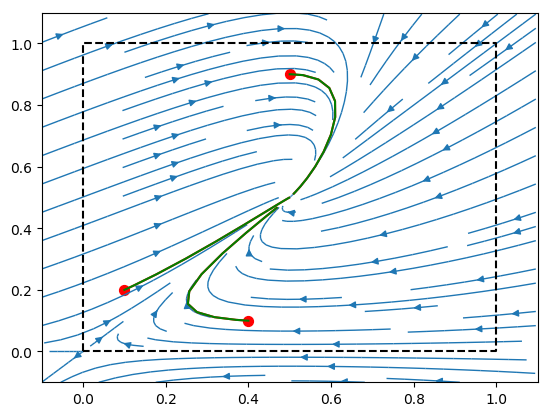


Solving ODE from x0=[0.5, 0.9]
Solving ODE from x0=[0.4, 0.1]
Solving ODE from x0=[0.4, 0.1]


(-0.1, 1.1)

In [267]:
# check that the objective value match
error_by_hand = map(ff, training_x[1, :], training_x[2, :]) -
    map(p_least_squares_as_f, training_x[1, :], training_x[2, :])
#error_by_hand = hcat(error_by_hand...)
objective_by_hand = norm(error_by_hand)
@show objective_by_hand
@show objective_value
error_norm_coeffs = norm(map(coefficients, p_least_squares-p_real))
@show error_norm_coeffs
p_real_as_f = (a, b) -> map(pi -> pi(x=>a, y=>b), p_real)

plot_vectorfield(p_least_squares_as_f, (-0.1, 1.1, 10), (-0.1, 1.1, 10))
for x0 in initial_conditions
    sol = solve_ode(ff, x0)
    PyPlot.plot(sol..., color=:red)
    PyPlot.scatter(x0[1], x0[2], color=:red, s=50)
    
    sol = solve_ode(p_least_squares_as_f, x0)
    PyPlot.plot(sol..., color=:green)
end

plot_box()
PyPlot.xlim(-0.1, 1.1)
PyPlot.ylim(-0.1, 1.1)